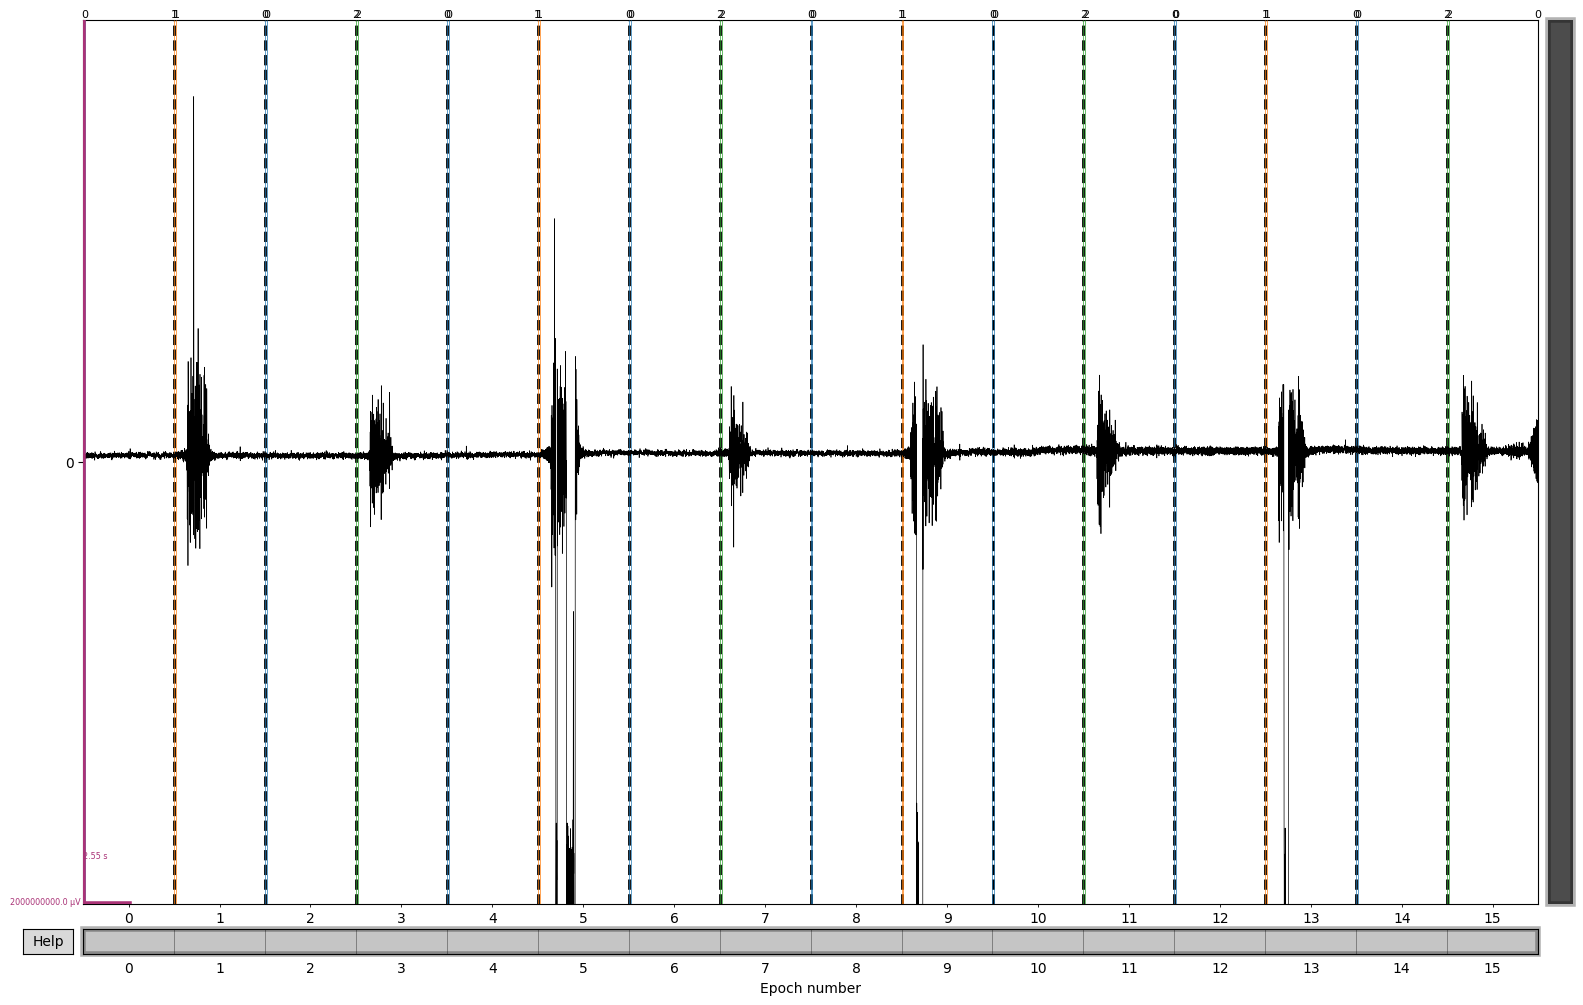

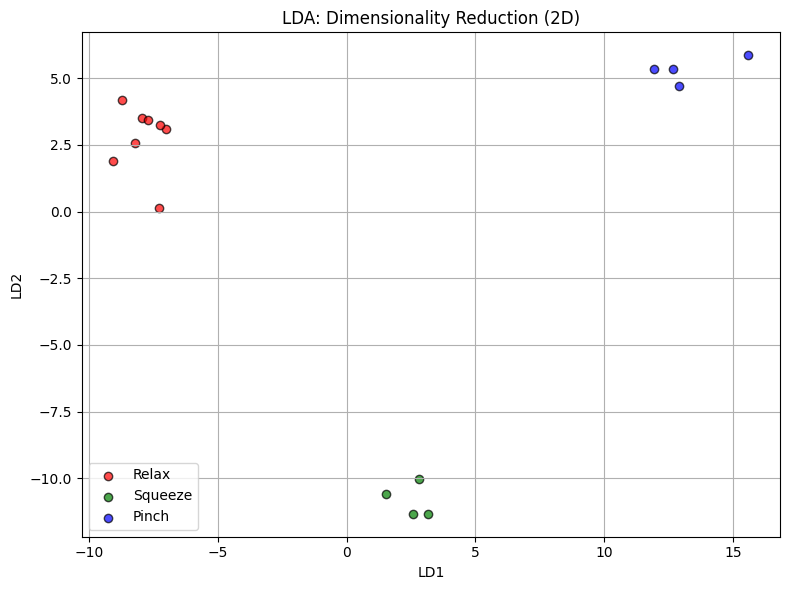

In [ ]:
import mne
from pathlib import Path
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
import numpy as np
import matplotlib.pyplot as plt
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Disable MNE logging output
mne.set_log_level('ERROR')


dataset_x = list()
dataset_y = list()



def load_events(file_path):
        events = np.loadtxt(file_path, delimiter=',', dtype=int)
        return events

def csv_to_dataframe(file):
        # print(BoardIds.GANGLION_BOARD.value)
        # eeg_channels_names = BoardShim.get_eeg_names(BoardIds.GANGLION_BOARD)
        # print(eeg_channels_names)
        eeg_channels_names = [str(i) for i in range(15)]
        df = pd.read_csv(file, usecols = eeg_channels_names).transpose()

        return df

def df_to_raw( df, sfreq=200, ch_types='emg'):
    # eeg_channels_names = BoardShim.get_eeg_names(self.board_id)
    eeg_channels_names = [str(i) for i in range(df.shape[0])]
    ch_types = ['eeg'] * len(eeg_channels_names)

    # Create MNE info object
    info = mne.create_info(ch_names = eeg_channels_names, sfreq = sfreq, ch_types=ch_types)

    # Create MNE raw object
    raw = mne.io.RawArray(df, info)
    raw.load_data()
    # raw.plot(clipping=None, scalings=dict(eeg='1e3', emg='1e5'))

    return raw

def csv_to_raw(file, start_channel=0, end_channel=15):
    df = csv_to_dataframe(file)
    df = df.iloc[start_channel:end_channel, :]
    raw = df_to_raw(df)
    return raw

def raw_to_epochs(raw, event_file, event_dict, tmin=-0.1, tmax=5.0, baseline=None, reject=None):
    events = np.array(load_events(event_file))  
    epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=tmin, tmax=tmax, preload=True, baseline=baseline, reject=reject)
    epochs.plot(scalings=dict(eeg='1e3', emg='1e5'), events=events)
    psd = epochs.compute_psd()
    # psd.plot()
    data = psd.get_data()
    # print("Shape::")
    # print(data.shape)
    # print(data[0, :, :].shape)

    # plt.figure()
    # plt.plot(np.log10(data[0, :, :].T))
    # plt.xlabel('Time Points')
    # plt.ylabel('Amplitude')
    # plt.title('EEG Signal for First Epoch')
    # plt.show()

    return epochs, events

def filter_data(raw, l_freq=1.0, h_freq=95.0):
    filtered = raw.copy().filter(l_freq=l_freq, h_freq=h_freq)
    filtered = filtered.notch_filter(freqs=60)
    return filtered

def plot_tfr(epochs, event):
    # Time frequency analysis
    fmax = 100
    freqs = np.logspace(*np.log10([1, fmax]), num=fmax)
    n_cycles = freqs / 2.0
    baseline = (-0.1, 0)

    epochs_tfr_relax = epochs_filtered[event].compute_tfr("morlet", n_cycles=n_cycles, return_itc=False, freqs=freqs, average=True, use_fft=True)
    epochs_tfr_relax.plot(title=event, baseline=baseline, mode="logratio") # vmax=1e-8,

def get_band_powers(epoch):
    [avgs, stddevs] = DataFilter.get_custom_band_powers(epoch, [(1,10), (10, 20), (20, 30), (40, 50), (50, 60), (70, 80), (80, 90)], [0], sfreq, False)
    return avgs

def plot_band_powers(avgs, title="Average Band Powers"):
    # Create bar plot of average band powers
    plt.figure(figsize=(10,6))
    bands = ['(1-10Hz)', '(10-20Hz)', '(20-30Hz)', '(40-50Hz)', 
            '(50-60Hz)', '(70-80Hz)', '(80-90Hz)']
    plt.bar(bands, avgs)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Power')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def get_band_power_by_epoch(epochs, epoch_index):
    selected_epoch = epochs[epoch_index, :, :].reshape(1, -1)
    avgs = get_band_powers(selected_epoch)
    return avgs
     
def add_data_and_labels(epochs, event_id, label):
    epochs_data = epochs[event_id].get_data()
    for i in range(epochs_data.shape[0]):
        avgs = get_band_power_by_epoch(epochs_data, i)
        dataset_x.append(avgs)
        dataset_y.append(label)

def get_lda(dataset_x, dataset_y, n_components=2):
     # Apply LDA to reduce to 2D
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_lda = lda.fit_transform(dataset_x, dataset_y)

    # Plot the reduced data
    plt.figure(figsize=(8, 6))
    colors = ['red', 'green', 'blue']
    for color, i, label in zip(colors, [0, 1, 2], ['Relax', 'Squeeze', 'Pinch']):
        plt.scatter(X_lda[dataset_y == i, 0], X_lda[dataset_y == i, 1], alpha=0.7, color=color, label=label, edgecolor='k')

    plt.title('LDA: Dimensionality Reduction (2D)')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

raw = csv_to_raw("data/study2_data.csv", 1, 2)
# filtered = filter_data(raw)
filtered = raw.notch_filter(freqs=60)

event_dict = {"relax": 0, "squeeze": 1, "pinch": 2}
sfreq = 200
epochs_filtered, events = raw_to_epochs(filtered, "events/study2.txt", event_dict)

for event_name, event_id in event_dict.items():
    add_data_and_labels(epochs_filtered, event_name, event_id)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

get_lda(dataset_x, dataset_y)

